In [762]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [763]:
# network structure. 
# not to include the input layer
#net_layers = (8, 5)  # (11,9,8,4)

epochs=1000
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

select_features = False

TRAIN_MODEL = True

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [764]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [765]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [766]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
3,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
4,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [767]:
data.shape

(6766, 18)

# Eliminate outlier noice

In [768]:
df = data

In [769]:
df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
count,"6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00","6,766.00"
mean,0.83,0.21,0.02,0.20,0.12,0.05,0.03,0.53,1.83,2.76,2.76,2.76,2.76,2.76,2.76,4.10,5.03,2.97
std,0.62,0.13,0.00,0.13,0.08,0.04,0.01,0.58,1.99,1.10,1.09,1.09,1.09,1.09,1.09,2.08,4.20,3.51
min,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.01,0.50,1.00,1.00,1.00,1.00,1.00,1.10,0.00,0.02
25%,0.19,0.08,0.02,0.05,0.03,0.04,0.02,0.12,0.02,2.00,2.00,2.00,2.00,2.00,2.00,1.92,0.49,0.24
50%,0.84,0.22,0.02,0.20,0.12,0.05,0.03,0.32,1.15,3.00,3.00,3.00,3.00,3.00,3.00,4.21,5.14,0.49
75%,1.29,0.30,0.02,0.30,0.18,0.06,0.04,0.58,3.28,4.00,4.00,4.00,4.00,4.00,4.00,5.78,8.20,5.81
max,2.73,0.91,0.04,0.64,0.34,0.63,0.10,2.53,6.58,4.00,4.00,4.00,4.00,4.00,4.00,9.66,20.13,9.75


shape before (6766, 18)
latency quantiles min 9.65 max 0.24
shape after (4233, 18)


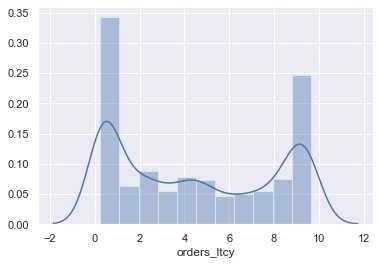

In [770]:
df = data
print('shape before {}'.format(df.shape))
if 1 == 1:
    minq = df['orders_ltcy'].quantile(0.3)
    maxq = df['orders_ltcy'].quantile(0.99)
    print('latency quantiles min {} max {}'.format(maxq, minq))
    df = df[df['orders_ltcy'] > minq]
    df = df[df['orders_ltcy'] < maxq]
    sns.distplot(df['orders_ltcy'])
print('shape after {}'.format(df.shape))   

In [771]:
data = df

# Shuffle

In [772]:
# shuffle the data
from sklearn.utils import shuffle
data = shuffle(data, random_state=0)
print('shape {}'.format(data.shape))
data.head(5)

shape (4233, 18)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
5616,0.04,0.05,0.02,0.04,0.02,0.05,0.04,0.05,0.02,4.00,4.00,4.00,4.00,4.00,4.00,1.36,0.00,1.18
2380,1.34,0.26,0.01,0.35,0.19,0.02,0.02,0.99,0.17,2.00,2.00,2.00,2.00,2.00,2.00,3.80,10.42,8.89
2693,1.37,0.37,0.02,0.39,0.22,0.04,0.02,1.10,1.86,2.00,2.00,2.00,2.00,2.00,2.00,4.76,9.07,8.91
2532,1.48,0.25,0.02,0.31,0.21,0.03,0.02,1.08,1.24,2.00,2.00,2.00,2.00,2.00,2.00,4.50,10.31,9.22
1052,0.08,0.08,0.01,0.03,0.02,0.03,0.02,0.07,0.18,2.00,2.00,2.00,2.00,2.00,2.00,1.26,0.33,0.28


In [773]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 17 features


In [774]:
# scale targets for better convergence
y_scaler =  MinMaxScaler()
targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

# Feature Selection

In [775]:
feature_list = inputs.columns.values
if select_features:
    sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold='0.02*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

In [776]:
n_inputs = len(feature_list)
n_inputs


17

In [777]:
#net_layers = (11, 8, 5, 2)  # (11,9,8,4)
net_layers = (13, 9)

In [778]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))

# for better convergence and result scale target to values between 0 - 1
if 1 == 0:
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


y_train (3809, 1) , y_test (424, 1)


# Scaling

In [779]:
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)  # fit on training data only
x_test = x_scaler.transform(x_test)

In [780]:
if 1 == 0:
    y_scaler =  MinMaxScaler()

    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

## Function to build a model

In [781]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    if isinstance(nodes, int) or not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal', activation='linear'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [782]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint(models_dir + 'best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

if TRAIN_MODEL:
    history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")


Train on 3047 samples, validate on 762 samples
Epoch 1/1000
3047/3047 [==============================] - 4s 1ms/step - loss: 0.3327 - mean_squared_error: 0.3327 - val_loss: 0.3428 - val_mean_squared_error: 0.3428

Epoch 00001: val_loss improved from inf to 0.34275, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.3201 - mean_squared_error: 0.3201 - val_loss: 0.3280 - val_mean_squared_error: 0.3280

Epoch 00002: val_loss improved from 0.34275 to 0.32801, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.3040 - mean_squared_error: 0.3040 - val_loss: 0.3076 - val_mean_squared_error: 0.3076

Epoch 00003: val_loss improved from 0.32801 to 0.30756, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_ml

3047/3047 [==============================] - 0s 14us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0716 - val_mean_squared_error: 0.0716

Epoch 00026: val_loss improved from 0.07268 to 0.07164, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 27/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0706 - val_mean_squared_error: 0.0706

Epoch 00027: val_loss improved from 0.07164 to 0.07060, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 28/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0696 - val_mean_squared_error: 0.0696

Epoch 00028: val_loss improved from 0.07060 to 0.06958, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 29/1000
3047/3047 [=================

3047/3047 [==============================] - 0s 15us/step - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0575 - val_mean_squared_error: 0.0575

Epoch 00051: val_loss improved from 0.05796 to 0.05750, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 52/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0569 - val_mean_squared_error: 0.0569

Epoch 00052: val_loss improved from 0.05750 to 0.05693, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 53/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0562 - val_mean_squared_error: 0.0562

Epoch 00053: val_loss improved from 0.05693 to 0.05623, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 54/1000
3047/3047 [=================

3047/3047 [==============================] - 0s 14us/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0484 - val_mean_squared_error: 0.0484

Epoch 00076: val_loss improved from 0.04847 to 0.04837, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 77/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0482 - val_mean_squared_error: 0.0482

Epoch 00077: val_loss improved from 0.04837 to 0.04819, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 78/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0481 - val_mean_squared_error: 0.0481

Epoch 00078: val_loss improved from 0.04819 to 0.04806, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 79/1000
3047/3047 [=================


Epoch 00103: val_loss improved from 0.04696 to 0.04695, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 104/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0469 - val_mean_squared_error: 0.0469

Epoch 00104: val_loss improved from 0.04695 to 0.04694, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 105/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0469 - val_mean_squared_error: 0.0469

Epoch 00105: val_loss improved from 0.04694 to 0.04693, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 106/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0469 - val_mean_squared_error: 0.0469

Epoch 00106: val_loss im

Epoch 129/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0467 - val_mean_squared_error: 0.0467

Epoch 00129: val_loss improved from 0.04670 to 0.04669, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 130/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0467 - val_mean_squared_error: 0.0467

Epoch 00130: val_loss improved from 0.04669 to 0.04668, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 131/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0467 - val_mean_squared_error: 0.0467

Epoch 00131: val_loss improved from 0.04668 to 0.04668, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 132/1000
3047/3047 

3047/3047 [==============================] - 0s 14us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0465 - val_mean_squared_error: 0.0465

Epoch 00154: val_loss improved from 0.04646 to 0.04645, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 155/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0464 - val_mean_squared_error: 0.0464

Epoch 00155: val_loss improved from 0.04645 to 0.04644, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 156/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0464 - val_mean_squared_error: 0.0464

Epoch 00156: val_loss improved from 0.04644 to 0.04643, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 157/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 14us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0462 - val_mean_squared_error: 0.0462

Epoch 00179: val_loss improved from 0.04624 to 0.04623, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 180/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0462 - val_mean_squared_error: 0.0462

Epoch 00180: val_loss improved from 0.04623 to 0.04622, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 181/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0462 - val_mean_squared_error: 0.0462

Epoch 00181: val_loss improved from 0.04622 to 0.04622, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 182/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 14us/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0460 - val_mean_squared_error: 0.0460

Epoch 00204: val_loss improved from 0.04605 to 0.04604, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 205/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0460 - val_mean_squared_error: 0.0460

Epoch 00205: val_loss improved from 0.04604 to 0.04603, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 206/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0460 - val_mean_squared_error: 0.0460

Epoch 00206: val_loss improved from 0.04603 to 0.04603, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 207/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 15us/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0458 - val_mean_squared_error: 0.0458

Epoch 00229: val_loss improved from 0.04586 to 0.04585, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 230/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0458 - val_mean_squared_error: 0.0458

Epoch 00230: val_loss improved from 0.04585 to 0.04584, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 231/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0458 - val_mean_squared_error: 0.0458

Epoch 00231: val_loss improved from 0.04584 to 0.04583, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 232/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 16us/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0457 - val_mean_squared_error: 0.0457

Epoch 00254: val_loss improved from 0.04568 to 0.04567, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 255/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0457 - val_mean_squared_error: 0.0457

Epoch 00255: val_loss improved from 0.04567 to 0.04566, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 256/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0457 - val_mean_squared_error: 0.0457

Epoch 00256: val_loss improved from 0.04566 to 0.04565, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 257/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 14us/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0455 - val_mean_squared_error: 0.0455

Epoch 00279: val_loss improved from 0.04551 to 0.04550, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 280/1000
3047/3047 [==============================] - 0s 14us/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0455 - val_mean_squared_error: 0.0455

Epoch 00280: val_loss improved from 0.04550 to 0.04549, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 281/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0455 - val_mean_squared_error: 0.0455

Epoch 00281: val_loss improved from 0.04549 to 0.04549, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 282/1000
3047/3047 [==============

Epoch 305/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0453 - val_mean_squared_error: 0.0453

Epoch 00305: val_loss improved from 0.04535 to 0.04534, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 306/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0453 - val_mean_squared_error: 0.0453

Epoch 00306: val_loss improved from 0.04534 to 0.04534, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 307/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0453 - val_mean_squared_error: 0.0453

Epoch 00307: val_loss improved from 0.04534 to 0.04533, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 308/1000
3047/3047 

3047/3047 [==============================] - 0s 16us/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0452 - val_mean_squared_error: 0.0452

Epoch 00330: val_loss improved from 0.04519 to 0.04519, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 331/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0452 - val_mean_squared_error: 0.0452

Epoch 00331: val_loss improved from 0.04519 to 0.04518, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 332/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0452 - val_mean_squared_error: 0.0452

Epoch 00332: val_loss improved from 0.04518 to 0.04517, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 333/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 15us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0451 - val_mean_squared_error: 0.0451

Epoch 00355: val_loss improved from 0.04506 to 0.04505, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 356/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0450 - val_mean_squared_error: 0.0450

Epoch 00356: val_loss improved from 0.04505 to 0.04505, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 357/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0450 - val_mean_squared_error: 0.0450

Epoch 00357: val_loss improved from 0.04505 to 0.04504, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 358/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 16us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0449 - val_mean_squared_error: 0.0449

Epoch 00381: val_loss improved from 0.04493 to 0.04492, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 382/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0449 - val_mean_squared_error: 0.0449

Epoch 00382: val_loss improved from 0.04492 to 0.04492, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 383/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0449 - val_mean_squared_error: 0.0449

Epoch 00383: val_loss did not improve from 0.04492
Epoch 384/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0449 - val_me

3047/3047 [==============================] - 0s 15us/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0448 - val_mean_squared_error: 0.0448

Epoch 00407: val_loss improved from 0.04482 to 0.04482, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 408/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0448 - val_mean_squared_error: 0.0448

Epoch 00408: val_loss improved from 0.04482 to 0.04481, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 409/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0448 - val_mean_squared_error: 0.0448

Epoch 00409: val_loss improved from 0.04481 to 0.04480, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 410/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 17us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0447 - val_mean_squared_error: 0.0447

Epoch 00432: val_loss improved from 0.04469 to 0.04469, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 433/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0447 - val_mean_squared_error: 0.0447

Epoch 00433: val_loss improved from 0.04469 to 0.04468, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 434/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0447 - val_mean_squared_error: 0.0447

Epoch 00434: val_loss improved from 0.04468 to 0.04468, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 435/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 15us/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0446 - val_mean_squared_error: 0.0446

Epoch 00457: val_loss improved from 0.04458 to 0.04457, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 458/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0446 - val_mean_squared_error: 0.0446

Epoch 00458: val_loss improved from 0.04457 to 0.04456, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 459/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0446 - val_mean_squared_error: 0.0446

Epoch 00459: val_loss improved from 0.04456 to 0.04456, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 460/1000
3047/3047 [==============

Epoch 483/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0445 - val_mean_squared_error: 0.0445

Epoch 00483: val_loss improved from 0.04447 to 0.04447, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 484/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0445 - val_mean_squared_error: 0.0445

Epoch 00484: val_loss improved from 0.04447 to 0.04447, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 485/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0445 - val_mean_squared_error: 0.0445

Epoch 00485: val_loss improved from 0.04447 to 0.04446, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 486/1000
3047/3047 

3047/3047 [==============================] - 0s 18us/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0443 - val_mean_squared_error: 0.0443

Epoch 00508: val_loss improved from 0.04431 to 0.04430, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 509/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0443 - val_mean_squared_error: 0.0443

Epoch 00509: val_loss improved from 0.04430 to 0.04430, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 510/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0443 - val_mean_squared_error: 0.0443

Epoch 00510: val_loss improved from 0.04430 to 0.04429, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 511/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 17us/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0442 - val_mean_squared_error: 0.0442

Epoch 00533: val_loss did not improve from 0.04416
Epoch 534/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0442 - val_mean_squared_error: 0.0442

Epoch 00534: val_loss improved from 0.04416 to 0.04416, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 535/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0441 - val_mean_squared_error: 0.0441

Epoch 00535: val_loss improved from 0.04416 to 0.04415, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 536/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0441 - val_me

Epoch 559/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0440 - val_mean_squared_error: 0.0440

Epoch 00559: val_loss improved from 0.04398 to 0.04398, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 560/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0440 - val_mean_squared_error: 0.0440

Epoch 00560: val_loss improved from 0.04398 to 0.04397, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 561/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0440 - val_mean_squared_error: 0.0440

Epoch 00561: val_loss improved from 0.04397 to 0.04396, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 562/1000
3047/3047 

3047/3047 [==============================] - 0s 18us/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0438 - val_mean_squared_error: 0.0438

Epoch 00584: val_loss improved from 0.04384 to 0.04383, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 585/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0438 - val_mean_squared_error: 0.0438

Epoch 00585: val_loss improved from 0.04383 to 0.04383, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 586/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0438 - val_mean_squared_error: 0.0438

Epoch 00586: val_loss improved from 0.04383 to 0.04382, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 587/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 19us/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0437 - val_mean_squared_error: 0.0437

Epoch 00609: val_loss improved from 0.04369 to 0.04368, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 610/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0437 - val_mean_squared_error: 0.0437

Epoch 00610: val_loss improved from 0.04368 to 0.04368, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 611/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0437 - val_mean_squared_error: 0.0437

Epoch 00611: val_loss improved from 0.04368 to 0.04368, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 612/1000
3047/3047 [==============

3047/3047 [==============================] - 0s 17us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00634: val_loss improved from 0.04359 to 0.04358, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 635/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00635: val_loss improved from 0.04358 to 0.04358, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 636/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00636: val_loss did not improve from 0.04358
Epoch 637/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0436 - val_me

Epoch 661/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0435 - val_mean_squared_error: 0.0435

Epoch 00661: val_loss improved from 0.04351 to 0.04350, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 662/1000
3047/3047 [==============================] - 0s 21us/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0435 - val_mean_squared_error: 0.0435

Epoch 00662: val_loss improved from 0.04350 to 0.04350, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 663/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0435 - val_mean_squared_error: 0.0435

Epoch 00663: val_loss improved from 0.04350 to 0.04350, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 664/1000
3047/3047 

3047/3047 [==============================] - 0s 16us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00687: val_loss did not improve from 0.04342
Epoch 688/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00688: val_loss improved from 0.04342 to 0.04342, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 689/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00689: val_loss did not improve from 0.04342
Epoch 690/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00690: val_loss improved from 0.04342 to 0.04342, saving model to /Users

3047/3047 [==============================] - 0s 18us/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00713: val_loss improved from 0.04336 to 0.04335, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 714/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0434 - val_mean_squared_error: 0.0434

Epoch 00714: val_loss did not improve from 0.04335
Epoch 715/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0433 - val_mean_squared_error: 0.0433

Epoch 00715: val_loss improved from 0.04335 to 0.04335, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 716/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0433 - val_me

3047/3047 [==============================] - 0s 17us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0433 - val_mean_squared_error: 0.0433

Epoch 00740: val_loss improved from 0.04329 to 0.04329, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 741/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0433 - val_mean_squared_error: 0.0433

Epoch 00741: val_loss improved from 0.04329 to 0.04328, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 742/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0433 - val_mean_squared_error: 0.0433

Epoch 00742: val_loss did not improve from 0.04328
Epoch 743/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0427 - mean_squared_error: 0.0427 - val_loss: 0.0433 - val_me

3047/3047 [==============================] - 0s 19us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00768: val_loss improved from 0.04322 to 0.04322, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 769/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00769: val_loss improved from 0.04322 to 0.04322, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 770/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00770: val_loss did not improve from 0.04322
Epoch 771/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0432 - val_me

3047/3047 [==============================] - 0s 17us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00795: val_loss improved from 0.04316 to 0.04316, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 796/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00796: val_loss improved from 0.04316 to 0.04315, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 797/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0431 - val_mean_squared_error: 0.0431

Epoch 00797: val_loss improved from 0.04315 to 0.04315, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 798/1000
3047/3047 [==============

Epoch 821/1000
3047/3047 [==============================] - 0s 15us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0431 - val_mean_squared_error: 0.0431

Epoch 00821: val_loss did not improve from 0.04307
Epoch 822/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0431 - val_mean_squared_error: 0.0431

Epoch 00822: val_loss improved from 0.04307 to 0.04306, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 823/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0431 - val_mean_squared_error: 0.0431

Epoch 00823: val_loss did not improve from 0.04306
Epoch 824/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0431 - val_mean_squared_error: 0.0431

Epoch 00824: val_loss improved from 0.04306 to 0.04306, saving 

Epoch 850/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0430 - val_mean_squared_error: 0.0430

Epoch 00850: val_loss did not improve from 0.04301
Epoch 851/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0430 - val_mean_squared_error: 0.0430

Epoch 00851: val_loss improved from 0.04301 to 0.04300, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 852/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0430 - val_mean_squared_error: 0.0430

Epoch 00852: val_loss did not improve from 0.04300
Epoch 853/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0430 - val_mean_squared_error: 0.0430

Epoch 00853: val_loss improved from 0.04300 to 0.04300, saving 

3047/3047 [==============================] - 0s 19us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00877: val_loss did not improve from 0.04294
Epoch 878/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00878: val_loss improved from 0.04294 to 0.04293, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 879/1000
3047/3047 [==============================] - 0s 16us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00879: val_loss improved from 0.04293 to 0.04293, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 880/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_me

Epoch 905/1000
3047/3047 [==============================] - 0s 19us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00905: val_loss improved from 0.04288 to 0.04288, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 906/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00906: val_loss improved from 0.04288 to 0.04287, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 907/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0429 - val_mean_squared_error: 0.0429

Epoch 00907: val_loss improved from 0.04287 to 0.04287, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 908/1000
3047/3047 

Epoch 932/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00932: val_loss did not improve from 0.04281
Epoch 933/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00933: val_loss did not improve from 0.04281
Epoch 934/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00934: val_loss improved from 0.04281 to 0.04280, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 935/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00935: val_loss improved from 0.04280 to 0.04280, saving 

Epoch 961/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00961: val_loss improved from 0.04277 to 0.04277, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 962/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00962: val_loss improved from 0.04277 to 0.04277, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 963/1000
3047/3047 [==============================] - 0s 20us/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0428 - val_mean_squared_error: 0.0428

Epoch 00963: val_loss improved from 0.04277 to 0.04276, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 964/1000
3047/3047 

3047/3047 [==============================] - 0s 19us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0427 - val_mean_squared_error: 0.0427

Epoch 00986: val_loss improved from 0.04267 to 0.04266, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 987/1000
3047/3047 [==============================] - 0s 18us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0427 - val_mean_squared_error: 0.0427

Epoch 00987: val_loss did not improve from 0.04266
Epoch 988/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0427 - val_mean_squared_error: 0.0427

Epoch 00988: val_loss improved from 0.04266 to 0.04265, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 989/1000
3047/3047 [==============================] - 0s 17us/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0426 - val_me

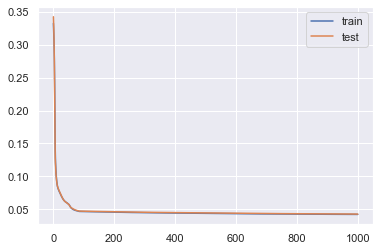

In [783]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [784]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.05  std: (0.02)


In [785]:
# load the saved model
saved_model = load_model(models_dir + 'best_mlp_model.h5')


In [786]:
# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))

Train MSE: 0.042, Test MSE: 0.042


In [787]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)

#y_train = y_scaler.inverse_transform(y_train.reshape(-1,1))
#y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))

In [788]:
y_train = y_train.reshape(-1)

In [789]:
y_train_together = pd.DataFrame(y_train, columns=['y_train_true'])
y_train_together['y_train_pred'] = y_hat
#y_train_together = y_train_together.reshape(-1,2)
y_train_together.head(5)

,y_train_true,y_train_pred
0,0.97,0.90
1,0.77,0.48
2,0.91,0.48
3,1.00,0.91
4,0.99,0.86


In [790]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.6961245195136807


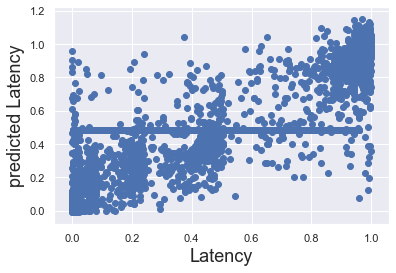

In [791]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

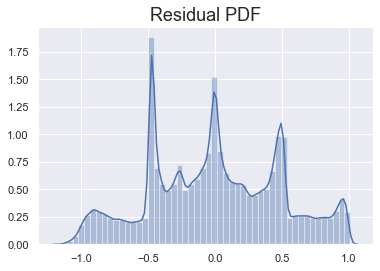

In [792]:
#y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [793]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: -0.00 std: 0.49  min; -1.15 max: 1.01


### Testing

In [794]:
y_hat_test = saved_model.predict(x_test)

#y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
#y_hat_test = y_scaler.inverse_transform(y_hat_test.reshape(-1,1))



In [795]:
y_test = y_test.reshape(-1)

In [796]:
y_test_together = pd.DataFrame(y_test, columns=['y_test_true'])
y_test_together['y_test_pred'] = y_hat_test
y_test_together.head(5)

,y_test_true,y_test_pred
0,0.96,0.85
1,0.01,0.14
2,0.93,0.79
3,0.20,0.29
4,0.00,0.03


<function matplotlib.pyplot.show(*args, **kw)>

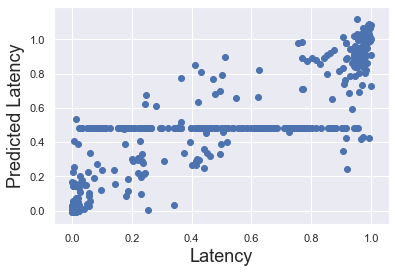

In [797]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

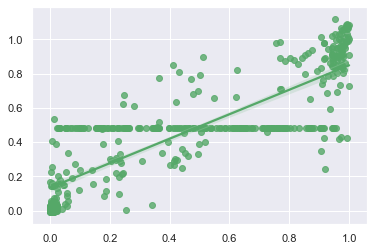

In [798]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [799]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
#y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.34,2.60
1,1.16,1.01
2,2.20,2.53
3,1.33,1.23
4,1.03,1.00


In [800]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.34,2.60,-0.27,10.22
1,1.16,1.01,0.15,14.62
2,2.20,2.53,-0.34,13.27
3,1.33,1.23,0.11,8.58
4,1.03,1.00,0.03,2.93
...,...,...,...,...
419,1.62,2.36,-0.74,31.26
420,2.80,2.70,0.10,3.69
421,1.62,1.88,-0.26,13.91
422,1.62,1.34,0.28,20.85


In [801]:
perf.describe()

,prediction,target,residual,difference%
count,424.00,424.00,424.00,424.00
mean,1.67,1.69,-0.03,14.93
std,0.55,0.64,0.36,14.87
min,0.99,1.00,-1.23,0.00
25%,1.19,1.05,-0.18,2.67
50%,1.62,1.52,0.00,9.94
75%,1.96,2.38,0.18,23.52
max,3.06,2.72,0.83,67.79


In [802]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
179,1.00,1.00,0.00,0.00
406,1.00,1.00,-0.00,0.01
113,1.02,1.02,0.00,0.03
96,1.00,1.00,0.00,0.05
119,1.00,1.00,-0.00,0.06
135,1.02,1.03,-0.00,0.06
366,1.25,1.25,-0.00,0.06
243,1.02,1.02,-0.00,0.15
101,1.06,1.06,-0.00,0.18
248,1.00,1.00,-0.00,0.19


# Prediction Accuracy

In [803]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.703385258656678


In [804]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.2044504201635824
